# Classic Design of Experiments I

In this notebook, we will learn about the basics of the classic design of experiments.

We start with an empirical analysis of **Hotelling's experiment** and end with a comparison of the **OFAT** and an **own DoE method**.

### **Table of Contents**
1. [Hottelling's Experiment](#hotelling-experiment)
2. [One-factor-at-a-time Method](#one-factor-at-time-method)
3. [Own Idea of a DoE Method](#own-idea-of-a-doe-method)

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from e2ml.experimentation import (
    get_hotellings_experiment_measurements,
    get_hotellings_experiment_errors,
    black_box_data_generation,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **1. Hotelling's Experiment** <a class="anchor" id="hotelling-experiment"></a>
This section empirically studies Hotelling's experiment extended to 16 objects. In the first step, we create the corresponding design/factor matrices for the OFAT and combinatorial method.

In [9]:
# Create Hadamard `X_hadamard` and identity matrix `X_identity`.
X_identity = np.eye(16)
X_hadamard = np.array([[1,1], [1,-1]])
size = 2
for _ in range(3):
    size *= 2
    new_hadamard = np.ndarray((size,size))
    new_hadamard[:size//2,:size//2] = X_hadamard
    new_hadamard[size//2:,:size//2] = X_hadamard
    new_hadamard[:size//2,size//2:] = X_hadamard
    new_hadamard[size//2:,size//2:] = -X_hadamard
    X_hadamard = new_hadamard
print(X_hadamard)


[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1.  1.  1. -1. -1. -1. -1.  1.  1.]
 [ 1. -1. -1.  1. -1.  1.  1. -1.  1. -1. -1.  1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1.]
 [ 1.  1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.]
 [ 1. -1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1. -1.]
 [ 1.  1.  1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.]
 [ 1. -1.  1. -1. -1.  1. -1.  1. -1.  1. -1.  1.  1. -1.  1. -1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1. 

Next, we implement a function to estimate the object weights from the experimental results obtained after executing the experimental trials according to a given design matrix.

In [11]:
def estimate_object_weights(X, y):
    """
    Gets a design matrix of object configurations and corresponding measurements as inputs
    to estimate the object weights.

    Parameters
    ----------
    X : numpy.ndarray of shape (16, 16)
        Design matrix of object configurations.
    y : numpy.ndarray of shape (16,)
        Measurements.

    Returns
    -------
    theta_hat : numpy.ndarray of shape (16,)
        Estimate object weights.
    """
    return np.linalg.inv(X) @ y


As the final step, we replicate the experiments for the OFAT and combinatorial method to estimate the expected sum of squared differences between true object and estimated object weights according to:

Ja, mit $\mathbf{E}$ und dann halt der Durchschnitt. $||\theta - \theta_{hat}||^2_2 = ||\mathbf{X}^{-1}\mathbf{\mu}- \mathbf{X}^{-1}\mathbf{y}||^2_2$


In [12]:
# Replicate the experiment 10,000 times for both design matrices
# to visualize the error distribution of the estimated weights via a histogram
# and compute the empirical mean of the sum of squared differences.
n_reps = 10000
errors_hadamard = np.zeros(n_reps)
errors_identitity = np.zeros(n_reps)
thetas_hadamard = []
thetas_identity = []

for rep in range(n_reps):
    y_hadamard = get_hotellings_experiment_measurements(X_hadamard)
    y_identity = get_hotellings_experiment_measurements(X_identity)
    theta_hat_hadamard = estimate_object_weights(X_hadamard, y_hadamard)
    theta_hat_identity = estimate_object_weights(X_identity, y_identity)
    errors_hadamard[rep] = get_hotellings_experiment_errors(theta_hat_hadamard)
    errors_identitity[rep] = get_hotellings_experiment_errors(theta_hat_identity)
    thetas_hadamard.append(theta_hat_hadamard)
    thetas_identity.append(theta_hat_identity)

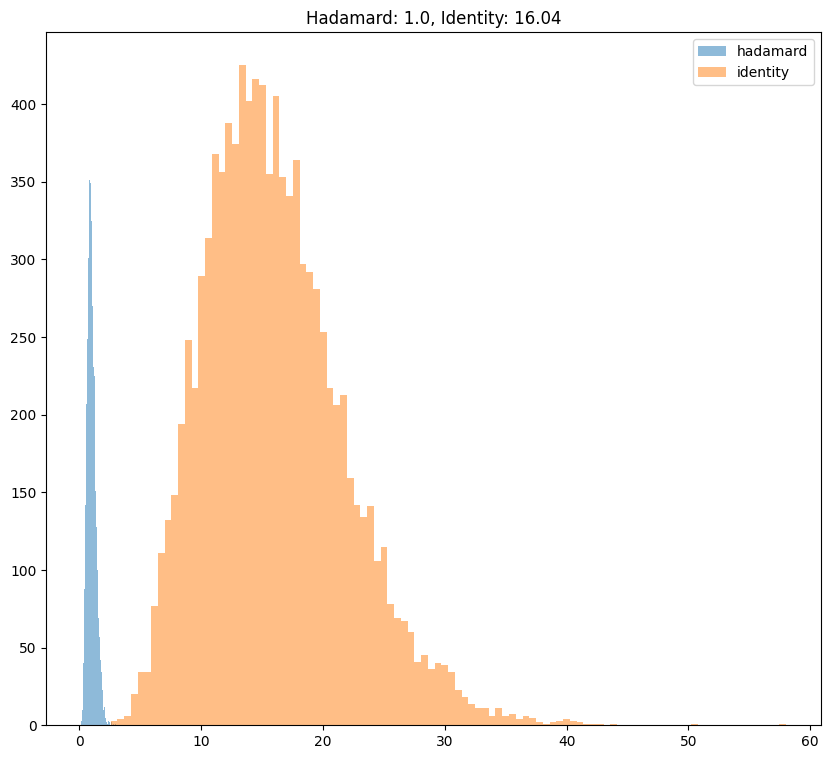

In [13]:
plt.figure(figsize=(10,9))
plt.title("Hadamard: {}, Identity: {}".format(errors_hadamard.mean().round(2), errors_identitity.mean().round(2)))
plt.hist(errors_hadamard, bins=100, label="hadamard", alpha=0.5)
plt.hist(errors_identitity, bins=100, label="identity", alpha=0.5)#
plt.legend()
plt.show()

#### **Question:**
1. (a) What are the expected sums of squared differences between estimated and true object weights for the OFAT and combinatorial method in the case of 16 objects?

   Sum of variances is 1 for identity and we sum over 16 so its about 16 and for the hadamard its variance is 1/16 and sum over 16, so we get 1
   
### **2. One-factor-at-a-time Method** <a class="anchor" id="one-factor-at-time-method"></a>
Now, we implement the standard OFAT method for multiple factors and levels. Therefore, we consider the factors $x_1, \dots, x_D$, where each factor has a finite number of levels, i.e., $x_d \in \{0, \dots, L_d-1\}, L_d \in \mathbb{N}_{>0}, d \in \{1, \dots, D\}$, where $x_1 = \dots = x_D = 0$ is defined as standard condition without loss of generality.

2. (a) How many conditions, i.e., the number of rows in the design matrix, will be generated by a standard OFAT method at maximum?

   $\sum_d (L_d) - D$ 
   
We need to implement the corresponding function [`one_factor_at_a_time`](../e2ml/experimentation/_one_factor_at_a_time.py) in the [`e2ml.experimentation`](../e2ml/experimentation) subpackage.
Once, the implementation has been completed, we check our implementation's validity. 

In [20]:
from e2ml.experimentation import one_factor_at_a_time

levels = [2, 3, 4]

# Obtain the design matrix `X` for the given levels.
X = one_factor_at_a_time(levels)
print(X)

assert X.shape[0] == 7, "The number of conditions is wrong."
assert X.shape[1] == 3, "The number of factors is wrong."
assert ~(((X > 0).sum(axis=-1) > 1).any()), "There is one row with more than one change factor."
for l_idx, l in enumerate(levels):
    assert np.array_equal(np.unique(X[:, l_idx]), np.arange(l)), f"No all levels were tested of factor {l_idx}."

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 2. 0.]
 [0. 0. 1.]
 [0. 0. 2.]
 [0. 0. 3.]]


Once we have implemented and tested our OFAT function, we apply it to a black-box experiment via the function `black_box_data_generation`. In total, there are
$D=4$ factors with $L_1 = 20, L_2 = 4, L_3 = 20, L_4 = 5$. For these factors, we generate a design matrix $\mathbf{X}$ according to a full OFAT method and obtain the corresponding measurements. The goal is to find a condition maximizing the response of the experiment.

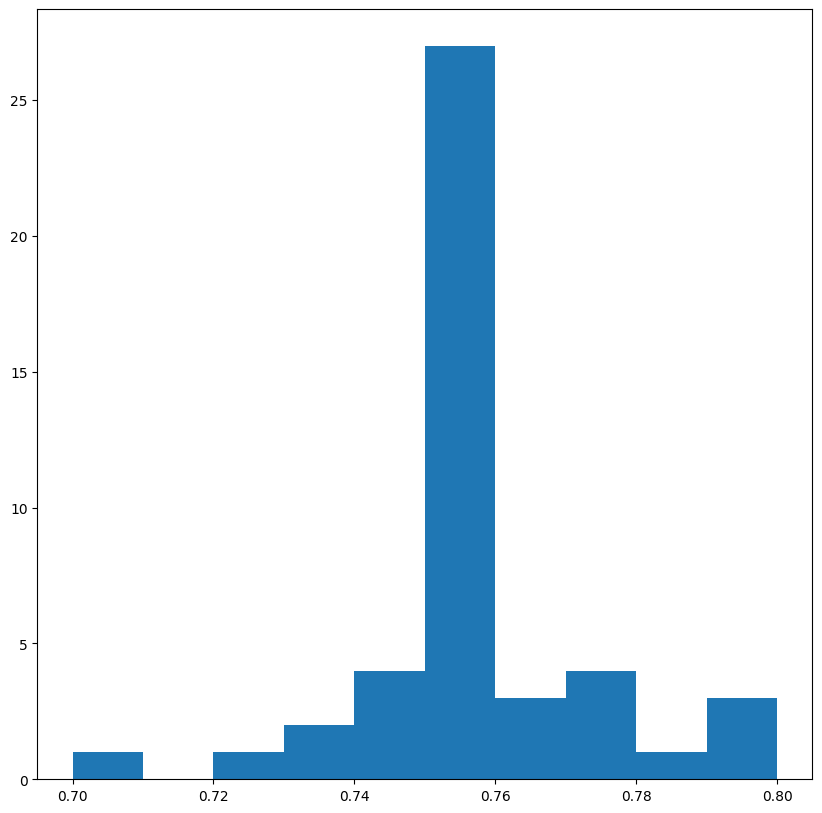

[5 0 0 0] is best result at score 0.8


In [23]:
# Generate levels according to the black-box experiment
levels = [20,4,20,5]

# Obtain the design matrix `X` for the given levels.
X = one_factor_at_a_time(levels)

# Perform experimental trials for the given matrix `X` and save the results `res`.
res = black_box_data_generation(X)

# Plot the obtained results as a histogram.
plt.figure(figsize=(10,10))
plt.hist(res)
plt.show()

# Print the best condition and its maximum score.
idx_max = res.argmax()
best_res = X[idx_max]
best_score = res[idx_max]
print(f"{best_res} is best result at score {best_score}")

### **3. Own Idea of a DoE Method** <a class="anchor" id="own-idea-of-a-doe-method"></a>
A substantial disadvantage of the OFAT method is that it ignores any interactions between varying levels of factors. Therefore, we aim to implement an own DoE method `own_doe_method`, which advances the OFAT method. The DOE method should allow restricting the number of conditions to a user-defined value. Implement and compare your method with the results of OFAT, when using the same number of experimental trials.

In [ ]:
# Implement `own_doe_method` taking `levels` as input.
# TODO

# Obtain the design matrix `X` for the given levels.
# TODO

# Perform experimental trials for the given matrix `X` and save the results `res`.
# TODO

# Plot the obtained results as a histogram.
# TODO

# Print the best condition and its maximum score.
# TODO
